In [26]:
from llm_lasso.data_splits import read_train_test_splits, read_baseline_splits
from llm_lasso.task_specific_lasso.llm_lasso import *
from llm_lasso.task_specific_lasso.plotting import plot_llm_lasso_result, plot_heatmap
import os
import json
import matplotlib.pyplot as plt
import pickle


In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plots for Paper

In [29]:
N_SPLITS = 10
DATASET="lung_TCGA"
BASE_FOLDER="data/experiment-results"
os.makedirs(f"{BASE_FOLDER}/{DATASET}", exist_ok=True)
splits = read_train_test_splits(f"data/splits/{DATASET}", N_SPLITS)

In [35]:
splits[9].x_test

,KRT5,KRT6A,DSG3,KRT14,KRT6B,KRT13,RPS4Y1,CLCA2,SFTPC,DSC3,...,LBP,SCN9A,PDK4,RBP1,RPS6KA6,IP6K3,MROH2A,INSM1,RASSF9,KYNU
0,8.539618,4.327863,4.655084,5.187169,4.035895,4.035895,4.192580,5.654892,12.668501,4.746455,...,5.858888,8.243881,12.502945,9.915339,5.858888,9.401721,3.593165,5.415224,8.533794,10.936047
1,7.317996,11.025574,2.966391,3.845216,7.098760,4.605132,4.034859,4.446441,15.756176,5.585200,...,11.214927,10.080304,12.026648,8.390111,8.827903,4.984013,3.945321,4.554634,11.420177,13.508119
2,10.186085,7.754929,4.077572,6.567743,4.697076,5.056462,12.969825,6.537595,16.396703,6.426739,...,4.430657,9.006282,10.960692,9.014459,7.402354,5.537946,8.904361,4.571505,7.885611,10.324033
3,8.475419,10.351275,4.724797,6.822169,8.376907,5.712858,12.534119,6.758857,13.249584,5.928328,...,3.811925,8.936474,9.563306,9.373552,8.280813,7.273671,6.279643,3.393671,8.364862,9.097947
4,7.582205,13.836778,5.272550,12.545973,9.458622,6.359938,3.989773,7.569783,16.689445,4.988670,...,4.906750,10.002717,11.007350,10.653454,6.648359,5.773456,3.989773,5.102487,8.520762,9.945068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,16.725576,18.175835,14.679811,7.758309,13.291456,8.462112,9.874889,13.699210,5.756891,13.987392,...,4.626478,11.749717,7.439392,13.354818,8.578742,3.767628,6.291561,4.085835,12.361042,12.140379
504,17.958288,9.370796,10.417291,9.381104,13.110740,10.850893,14.124113,6.793972,6.565788,13.177900,...,2.966391,4.253576,8.055454,10.735934,8.130743,2.966391,7.653932,3.952688,5.790516,9.650190
505,17.711967,17.633981,15.015253,14.001613,13.934084,16.660234,2.966391,14.833241,5.331200,14.489658,...,7.419839,10.607214,7.067975,11.221813,8.995596,5.030991,7.644832,4.379181,10.503518,9.304159
506,18.328588,17.240685,15.175287,11.682376,11.534301,14.790542,2.966391,11.611864,5.724781,14.968272,...,3.421384,8.085995,8.194282,14.210637,6.991420,4.218934,5.097052,4.142357,9.206695,6.850928


In [235]:
feature_baseline = read_baseline_splits(f"data/baselines/{DATASET}", n_splits=N_SPLITS, n_features=49)
with open(f"data/llm-score/{DATASET}/trial_scores_llm_score.json") as f:
    llm_score = json.load(f)
features = splits[0].x_train.columns
scores = np.mean(np.array([scores["scores"] for scores in llm_score]), axis=0)
llm_score_features = features[np.argsort(-scores)].tolist()
feature_baseline["llm_score"] = [llm_score_features] * N_SPLITS


In [55]:
# config = LLMLassoExperimentConfig(
#     folds_cv=5,
#     regression=False,
#     max_features_for_baselines=30,
#     n_threads=8,

#     # Lasso config
#     lambda_min_ratio=0.001,
#     relaxed_lasso=False,
#     lasso_downstream_l2=True,
#     max_imp_power=4,

#     remove_correlated_features=False,
#     run_pure_lasso_after=8
# )

## Lung_TCGA
config = LLMLassoExperimentConfig(
    folds_cv=5,
    regression=False,
    max_features_for_baselines=30,
    n_threads=8,

    # Lasso config
    lambda_min_ratio=0.001,
    relaxed_lasso=False,
    lasso_downstream_l2=True,
    max_imp_power=1,

    run_pure_lasso_after=10,
    cross_val_metric=CrossValMetric.ERROR
)

In [36]:
RERUN_BASELINES = False

baseline_csv = f"{BASE_FOLDER}/{DATASET}/baselines.csv"
if not RERUN_BASELINES and os.path.exists(baseline_csv):
    print(f"CSV found at {baseline_csv}. Loading.")
    baselines = pd.read_csv(baseline_csv)
else:
    baselines = run_downstream_baselines_for_splits(
        splits=splits,
        feature_baseline=feature_baseline,
        config=config
    )
    baselines.to_csv(baseline_csv, index=False)

CSV found at data/experiment-results/lung_TCGA/baselines.csv. Loading.


In [42]:
RERUN_LASSO = True
EXPERIMENT_NAME = "logistic"

lasso_csv = f"{BASE_FOLDER}/{DATASET}/lasso_{EXPERIMENT_NAME}.csv"

if not RERUN_LASSO and os.path.exists(lasso_csv):
    print(f"CSV found at {lasso_csv}. Loading.")
    lasso = pd.read_csv(lasso_csv)
else:
    lasso = run_lasso_baseline_for_splits(
        splits=splits,
        config=config
    )
    lasso.to_csv(lasso_csv, index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


In [49]:
## DLBCL vs. FL
# penalties_plain = np.array(np.load("data/llm-lasso/ash/scores-o1-5x/DLBCL_FL/final_scores_plain.pkl", allow_pickle=True))
# penalties_rag = np.array(np.load("data/llm-lasso/ash/scores-o1-5x/DLBCL_FL/final_scores_RAG.pkl", allow_pickle=True))

## DLBCL vs. MCL
# penalties_plain = np.array(np.load("data/llm-lasso/ash/cHL_plain.pkl", allow_pickle=True))
# penalties_rag = np.array(np.load("data/llm-lasso/ash/cHL_RAG.pkl", allow_pickle=True))

penalties_plain = np.array(np.load("data/llm-lasso/Lung_TCGA--3/final_scores_plain.pkl", allow_pickle=True))
# penalties_rag = np.array(np.load("data/llm-lasso/Lung_TCGA--2/final_scores_RAG.pkl", allow_pickle=True))


In [50]:
# with open("data/llm-lasso/ash/scores-o1-5x/DLBCL_FL/trial_scores_RAG.json") as f:
#     trial_scores_rag = np.array([x["scores"] for x in json.load(f)])
# with open("data/llm-lasso/ash/scores-o1-5x/DLBCL_FL/trial_scores_plain.json") as f:
#     trial_scores_plain = np.array([x["scores"] for x in json.load(f)])

with open("data/llm-lasso/Lung_TCGA--2/trial_scores_RAG.json") as f:
    trial_scores_rag = np.array([x["scores"][0] for x in json.load(f)])
penalties_rag = trial_scores_rag.mean(axis=0)
with open("data/llm-lasso/Lung_TCGA--3/trial_scores_plain.json") as f:
    trial_scores_plain = np.array([x["scores"][0] for x in json.load(f)])

In [53]:
trial_scores_rag + 2

array([[2.2 , 2.2 , 2.3 , ..., 3.  , 3.  , 3.  ],
       [2.15, 2.15, 2.2 , ..., 3.  , 3.  , 2.8 ],
       [2.1 , 2.2 , 2.2 , ..., 3.  , 3.  , 3.  ]])

In [58]:
RERUN_LLM_LASSO = True
EXPERIMENT_NAME = "logistic_trial_scores_4"
# EXPERIMENT_NAME = "logistic"

llm_lasso_csv = f"{BASE_FOLDER}/{DATASET}/llm_lasso_{EXPERIMENT_NAME}.csv"

if not RERUN_LLM_LASSO and os.path.exists(llm_lasso_csv):
    print(f"CSV found at {llm_lasso_csv}. Loading.")
    llm_lasso = pd.read_csv(llm_lasso_csv)
else:
    llm_lasso = run_llm_lasso_cv_for_splits(
        splits=splits,
        scores={
            # "plain": penalties_plain * 3 + 2 ,
            "rag": penalties_rag + 2
        },
        config=config,
        verbose=True,
        # preselected_genes=preselected_feature_names
        score_trial_list={
            # "plain": trial_scores_plain * 3 + 2,
            "rag": trial_scores_rag + 2
        }
    )
    llm_lasso.to_csv(llm_lasso_csv, index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Running model: rag
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
Running pf_type 1/imp^1-trial0
Running pf_type 1/imp^1-trial1
Running pf_type 1/imp^1-trial2


 10%|█         | 1/10 [00:10<01:36, 10.68s/it]

Running model: rag
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
1/imp^1 0.16415744515628033 0.0
Running pf_type 1/imp^1-trial0
Running pf_type 1/imp^1-trial1
1/imp^1-trial1 0.2022524752475247 0.16415744515628033
Running pf_type 1/imp^1-trial2


 20%|██        | 2/10 [00:19<01:15,  9.47s/it]

Running model: rag
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
1/imp^1 0.3027082119976703 0.0
Running pf_type 1/imp^1-trial0
Running pf_type 1/imp^1-trial1
Running pf_type 1/imp^1-trial2
1/imp^1-trial2 0.3159499773506762 0.3027082119976703


 30%|███       | 3/10 [00:27<01:03,  9.10s/it]

Running model: rag
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
Running pf_type 1/imp^1-trial0
Running pf_type 1/imp^1-trial1
1/imp^1-trial1 0.006911279363230369 0.0
Running pf_type 1/imp^1-trial2
1/imp^1-trial2 0.11005629974762196 0.006911279363230369


 40%|████      | 4/10 [00:37<00:54,  9.08s/it]

Running model: rag
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
Running pf_type 1/imp^1-trial0
Running pf_type 1/imp^1-trial1
Running pf_type 1/imp^1-trial2
1/imp^1-trial2 0.03660454280722177 0.0


 50%|█████     | 5/10 [00:45<00:44,  8.90s/it]

Running model: rag
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
1/imp^1 0.0985779460298972 0.0
Running pf_type 1/imp^1-trial0
Running pf_type 1/imp^1-trial1
1/imp^1-trial1 0.21175499902931483 0.0985779460298972
Running pf_type 1/imp^1-trial2


 60%|██████    | 6/10 [00:54<00:35,  8.83s/it]

Running model: rag
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
Running pf_type 1/imp^1-trial0
Running pf_type 1/imp^1-trial1
Running pf_type 1/imp^1-trial2


 70%|███████   | 7/10 [01:03<00:26,  8.89s/it]

Running model: rag
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
1/imp^1 0.31833139196272586 0.0
Running pf_type 1/imp^1-trial0
Running pf_type 1/imp^1-trial1
Running pf_type 1/imp^1-trial2


 80%|████████  | 8/10 [01:13<00:18,  9.33s/it]

Running model: rag
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
1/imp^1 0.12344690351388096 0.0
Running pf_type 1/imp^1-trial0
Running pf_type 1/imp^1-trial1
1/imp^1-trial1 0.12396622015142705 0.12344690351388096
Running pf_type 1/imp^1-trial2


 90%|█████████ | 9/10 [01:22<00:09,  9.32s/it]

Running model: rag
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
1/imp^1 0.13079984469035144 0.0
Running pf_type 1/imp^1-trial0
1/imp^1-trial0 0.14420824435384713 0.13079984469035144
Running pf_type 1/imp^1-trial1
Running pf_type 1/imp^1-trial2
1/imp^1-trial2 0.1578188701223064 0.14420824435384713


100%|██████████| 10/10 [01:32<00:00,  9.21s/it]


In [59]:
llm_lasso = llm_lasso[llm_lasso["method_model"] == "1/imp - rag"]
llm_lasso.loc[llm_lasso["method_model"] == "1/imp - rag", "method_model"] = "RAG LLM-Lasso (Ours)"
llm_lasso.loc[llm_lasso["method_model"] == "1/imp - plain", "method_model"] = "Plain LLM-Lasso (Ours)"

dataframes_to_plot = [
    baselines, lasso, llm_lasso
]
# dataframes_to_plot = [
#     lasso, llm_lasso
# ]
dataframes_to_plot = [df[df["n_features"] > 0] for df in dataframes_to_plot]

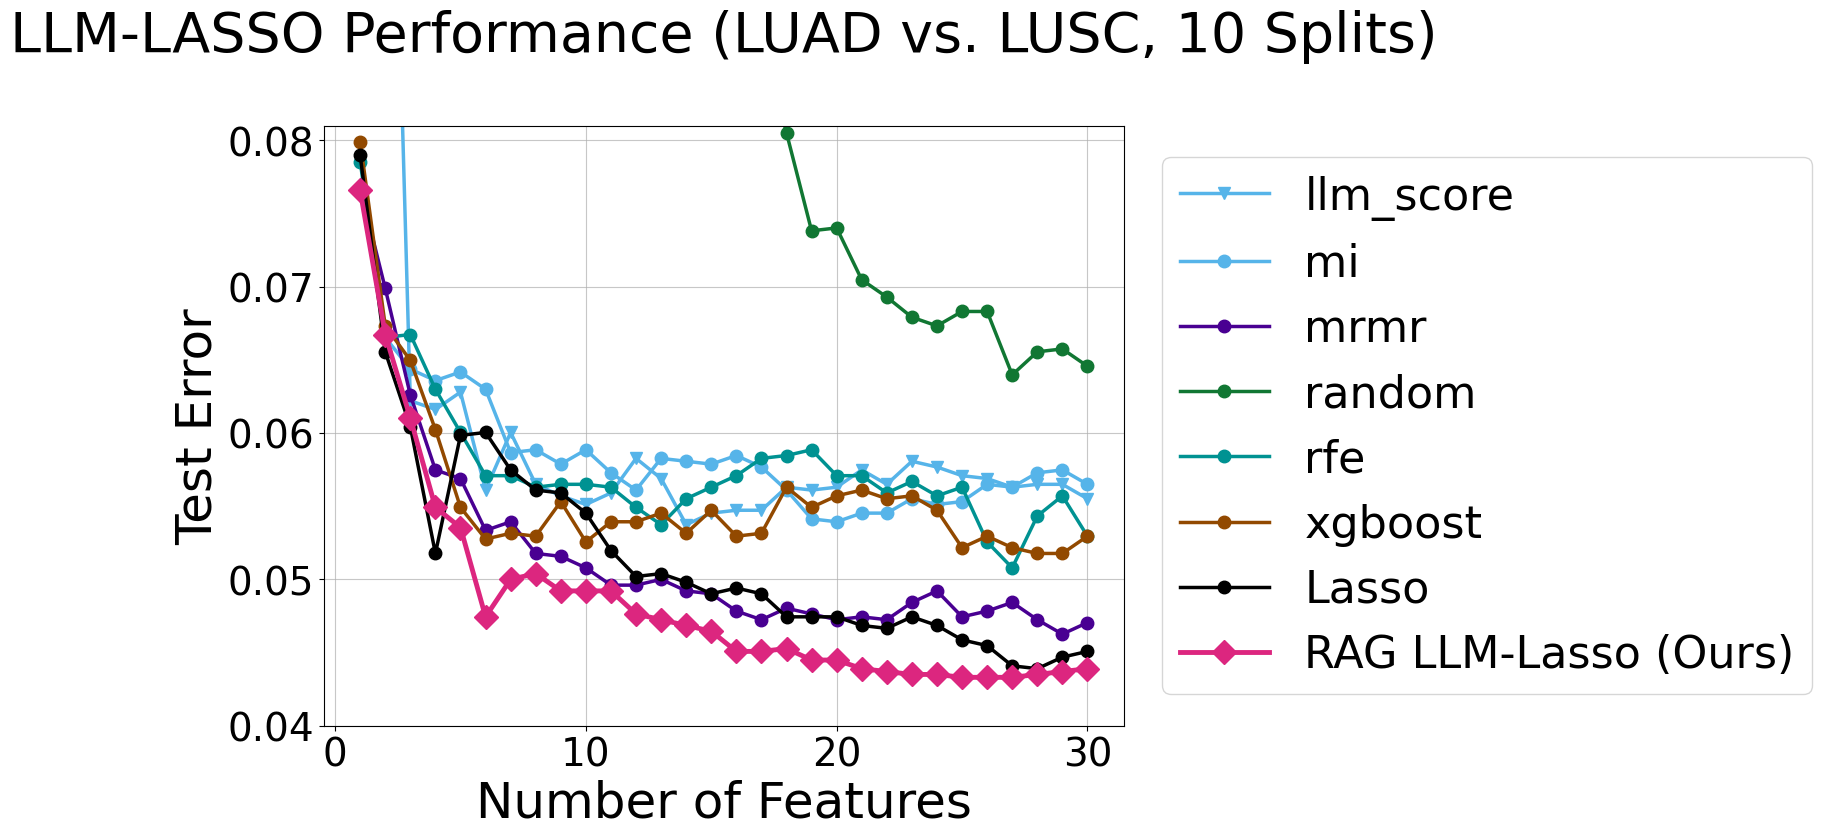

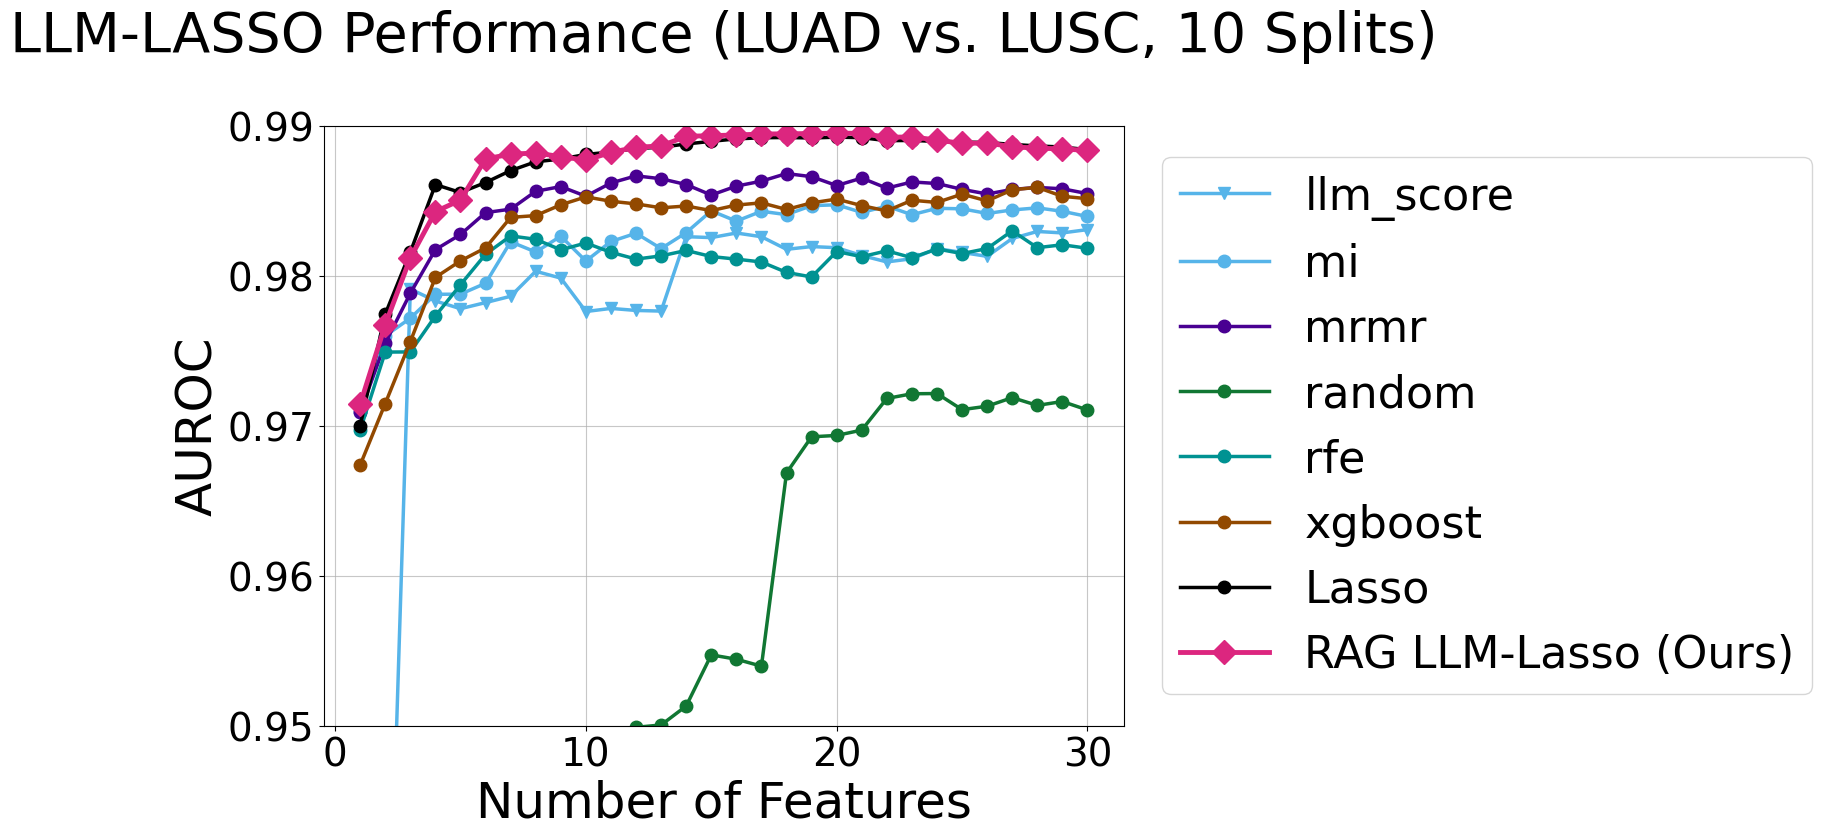

In [60]:
plot_llm_lasso_result(
    dataframes_to_plot,
    bolded_methods=["RAG LLM-Lasso (Ours)"],
    x_lim=30,
    task="LUAD vs. LUSC",
    plot_error_bars=False,
    test_error_y_lim=(0.04, 0.081),
    auroc_y_lim=(0.95, 0.99)
)

In [380]:
all_results = pd.concat(dataframes_to_plot, ignore_index=True).copy()

In [381]:
all_results[all_results["method_model"] == "Lasso"]["is_baseline"]

1800    False
1801    False
1802    False
1803    False
1804    False
        ...  
2438    False
2439    False
2440    False
2441    False
2442    False
Name: is_baseline, Length: 643, dtype: bool

In [366]:
N_FEAT = 30

In [367]:
for method_model in all_results["method_model"].unique():
    for split in range(10):
        prev_row = None
        for nfeat in range(N_FEAT+1):
            row = all_results[
                np.bitwise_and(
                    all_results["method_model"] == method_model,
                    np.bitwise_and(
                        all_results["split"] == split,
                        all_results["n_features"] == nfeat))
                ]
            if row.shape[0] == 1:
                prev_row = row.copy()
            elif row.shape[0] == 0:
                if prev_row is not None:
                    prev_row["n_features"] = nfeat
                    all_results = pd.concat([all_results, prev_row], ignore_index=True)

In [371]:
all_results = all_results[all_results["n_features"] <= N_FEAT]
all_results = all_results[all_results["method_model"].isin(["xgboost", "RAG LLM-Lasso (Ours)"])]

In [382]:
method_counts = pd.DataFrame()

for s in range(10):
    split = all_results[all_results["split"] == s]
    split_reversed = split.iloc[::-1].reset_index(drop=True)
    best_methods = (
        split.loc[
            split.groupby('n_features')['test_error'].idxmin()
        ][['n_features', 'method_model', 'test_error']]
        .reset_index(drop=True)
    )
    best_methods_rev = (
        split_reversed.loc[
            split_reversed.groupby('n_features')['test_error'].idxmin()
        ][['n_features', 'method_model', 'test_error']]
        .reset_index(drop=True)
    )
    best_methods = best_methods[best_methods["method_model"] == best_methods_rev["method_model"]]
    # print(best_methods)
    df = best_methods['method_model'].value_counts().reset_index() 
    df["split"] = s
    method_counts = pd.concat([df, method_counts], axis=0).copy()

# area = all_results.groupby(["split", "method_model"]).agg(
#     area=("test_error", "sum")
# ).reset_index()

In [383]:
method_counts.groupby("method_model").agg(
    mean=("count", "mean"),
    sd=("count", "std")
).reset_index()

,method_model,mean,sd
0,Lasso,27.000000,9.718253
1,RAG LLM-Lasso (Ours),31.400000,9.033272
2,llm_score,1.333333,0.577350
3,mi,1.000000,0.000000
4,mrmr,5.111111,3.407508
5,rfe,2.166667,1.602082
6,xgboost,4.400000,5.983310


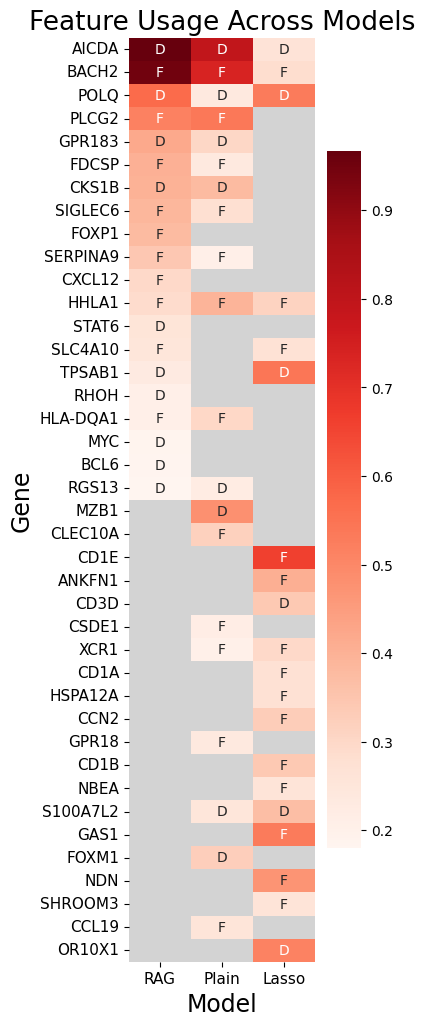

In [264]:
plot_heatmap(
    dataframes_to_plot,
    method_models=["RAG LLM-Lasso (Ours)", "Plain LLM-Lasso (Ours)", "Lasso"], # these are from the method_model column of the dataframe
    labels=["RAG", "Plain", "Lasso"], # this is how each method_model will be labeled on the plot
    feature_names=splits[0].x_train.columns,
    sort_by="RAG",
    pos_marker="F",
    neg_marker="D",
    top=20
)

### Small-Scale

In [4]:
N_SPLITS = 10
DATASET="bank"
BASE_FOLDER="data/experiment-results/small-scale"
os.makedirs(f"{BASE_FOLDER}/{DATASET}", exist_ok=True)
splits = read_train_test_splits(f"data/splits/{DATASET}", N_SPLITS)
# splits = read_train_test_splits(f"data/splits/small_scale_glioma", N_SPLITS)

In [5]:
feature_baseline = read_baseline_splits(f"data/baselines/{DATASET}", n_splits=N_SPLITS, n_features=len(splits[0].x_train.columns))
# feature_baseline = read_baseline_splits(f"data/baselines/small_scale_glioma", n_splits=N_SPLITS, n_features=len(splits[0].x_train.columns))


with open(f"erica-scores/scores/llm_scores/{DATASET}/gpt-4o/trial_scores_llmselect.json") as f:
    llm_score = json.load(f)
features = splits[0].x_train.columns
scores = np.mean(np.array([scores["scores"] for scores in llm_score]), axis=0)
llm_score_features = features[np.argsort(-scores)].tolist()
feature_baseline["llm_score"] = [llm_score_features] * N_SPLITS

with open(f"erica-scores/scores/lmpriors/{DATASET}/selected_features.txt", "r") as f:
    lmpriors = [x.strip() for x in f.readlines()]
feature_baseline["lmpriors"] = [lmpriors] * N_SPLITS

In [6]:
duration_idx = splits[0].x_train.columns.tolist().index("duration")
for i in range(N_SPLITS):
    splits[i].x_train = splits[i].x_train.drop("duration", axis=1)
    splits[i].x_test = splits[i].x_test.drop("duration", axis=1)

    for key in feature_baseline:
        if "duration" in feature_baseline[key][i]:
            feature_baseline[key][i].remove("duration")

In [18]:
config = LLMLassoExperimentConfig(
    folds_cv=5,
    regression=False,
    max_features_for_baselines=30,
    n_threads=8,

    # Lasso config
    lambda_min_ratio=0.001,
    relaxed_lasso=False,
    lasso_downstream_l2=True,
    max_imp_power=4,

    run_pure_lasso_after=5,
    cross_val_metric=CrossValMetric.ERROR
)

In [19]:
RERUN_BASELINES = True

baseline_csv = f"{BASE_FOLDER}/{DATASET}/baselines.csv"
if not RERUN_BASELINES and os.path.exists(baseline_csv):
    print(f"CSV found at {baseline_csv}. Loading.")
    baselines = pd.read_csv(baseline_csv)
else:
    baselines = run_downstream_baselines_for_splits(
        splits=splits,
        feature_baseline=feature_baseline,
        config=config
    )
    baselines.to_csv(baseline_csv, index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [20]:
RERUN_LASSO = True
EXPERIMENT_NAME = "logistic"

lasso_csv = f"{BASE_FOLDER}/{DATASET}/lasso_{EXPERIMENT_NAME}.csv"

if not RERUN_LASSO and os.path.exists(lasso_csv):
    print(f"CSV found at {lasso_csv}. Loading.")
    lasso = pd.read_csv(lasso_csv)
else:
    lasso = run_lasso_baseline_for_splits(
        splits=splits,
        config=config
    )
    lasso.to_csv(lasso_csv, index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:50<00:00,  5.01s/it]


In [21]:
penalties_plain = np.array(np.load(f"erica-scores/scores/our_scores/{DATASET}/gpt-4o/gene_scores_RAG.pkl", allow_pickle=True))
penalties_plain = np.array(list(penalties_plain[:duration_idx]) + list(penalties_plain[duration_idx+1:]))

In [22]:
penalties_plain

array([3., 2., 4., 3., 2., 2., 3., 3., 4., 5., 4., 3., 3., 3.])

In [23]:
RERUN_LLM_LASSO = True
EXPERIMENT_NAME = "plain"

llm_lasso_csv = f"{BASE_FOLDER}/{DATASET}/llm_lasso_{EXPERIMENT_NAME}.csv"

if not RERUN_LLM_LASSO and os.path.exists(llm_lasso_csv):
    print(f"CSV found at {llm_lasso_csv}. Loading.")
    llm_lasso = pd.read_csv(llm_lasso_csv)
else:
    llm_lasso = run_llm_lasso_cv_for_splits(
        splits=splits,
        scores={
            "plain": penalties_plain
        },
        config=config,
        verbose=True,
    )
    llm_lasso.to_csv(llm_lasso_csv, index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Running model: plain
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4


 10%|█         | 1/10 [00:19<02:54, 19.44s/it]

Running model: plain
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4
1/imp^4 3.216353145518713e-05 0.0


/home/nsagan/micromamba/envs/llm-lasso/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nsagan/micromamba/envs/llm-lasso/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Running model: plain
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4


 30%|███       | 3/10 [00:57<02:12, 18.91s/it]

Running model: plain
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4


 40%|████      | 4/10 [01:17<01:56, 19.33s/it]

Running model: plain
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4


 50%|█████     | 5/10 [01:37<01:38, 19.73s/it]

Running model: plain
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4


 60%|██████    | 6/10 [01:56<01:17, 19.44s/it]

Running model: plain
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
Running pf_type 1/imp^2
1/imp^2 0.00012932419939296058 0.0
Running pf_type 1/imp^3
1/imp^3 0.00019395488939071004 0.00012932419939296058
Running pf_type 1/imp^4
1/imp^4 0.00058225205445607 0.00019395488939071004


/home/nsagan/micromamba/envs/llm-lasso/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nsagan/micromamba/envs/llm-lasso/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Running model: plain
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4


 80%|████████  | 8/10 [02:38<00:40, 20.21s/it]

Running model: plain
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4


 90%|█████████ | 9/10 [02:58<00:20, 20.18s/it]

Running model: plain
Running pf_type 1/imp^0
1/imp^0 0.0 -inf
Running pf_type 1/imp^1
1/imp^1 0.00022656862652709053 0.0
Running pf_type 1/imp^2
1/imp^2 0.00029126213592219063 0.00022656862652709053
Running pf_type 1/imp^3
1/imp^3 0.00029134589511865816 0.00029126213592219063
Running pf_type 1/imp^4


/home/nsagan/micromamba/envs/llm-lasso/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 10/10 [03:19<00:00, 19.92s/it]


In [24]:
llm_lasso.loc[llm_lasso["method_model"] == "1/imp - rag", "method_model"] = "RAG LLM-Lasso (Ours)"
llm_lasso.loc[llm_lasso["method_model"] == "1/imp - plain", "method_model"] = "Plain LLM-Lasso (Ours)"

dataframes_to_plot = [
    lasso, llm_lasso
]
# dataframes_to_plot = [
#     lasso, llm_lasso
# ]
dataframes_to_plot = [df[df["n_features"] > 0] for df in dataframes_to_plot]

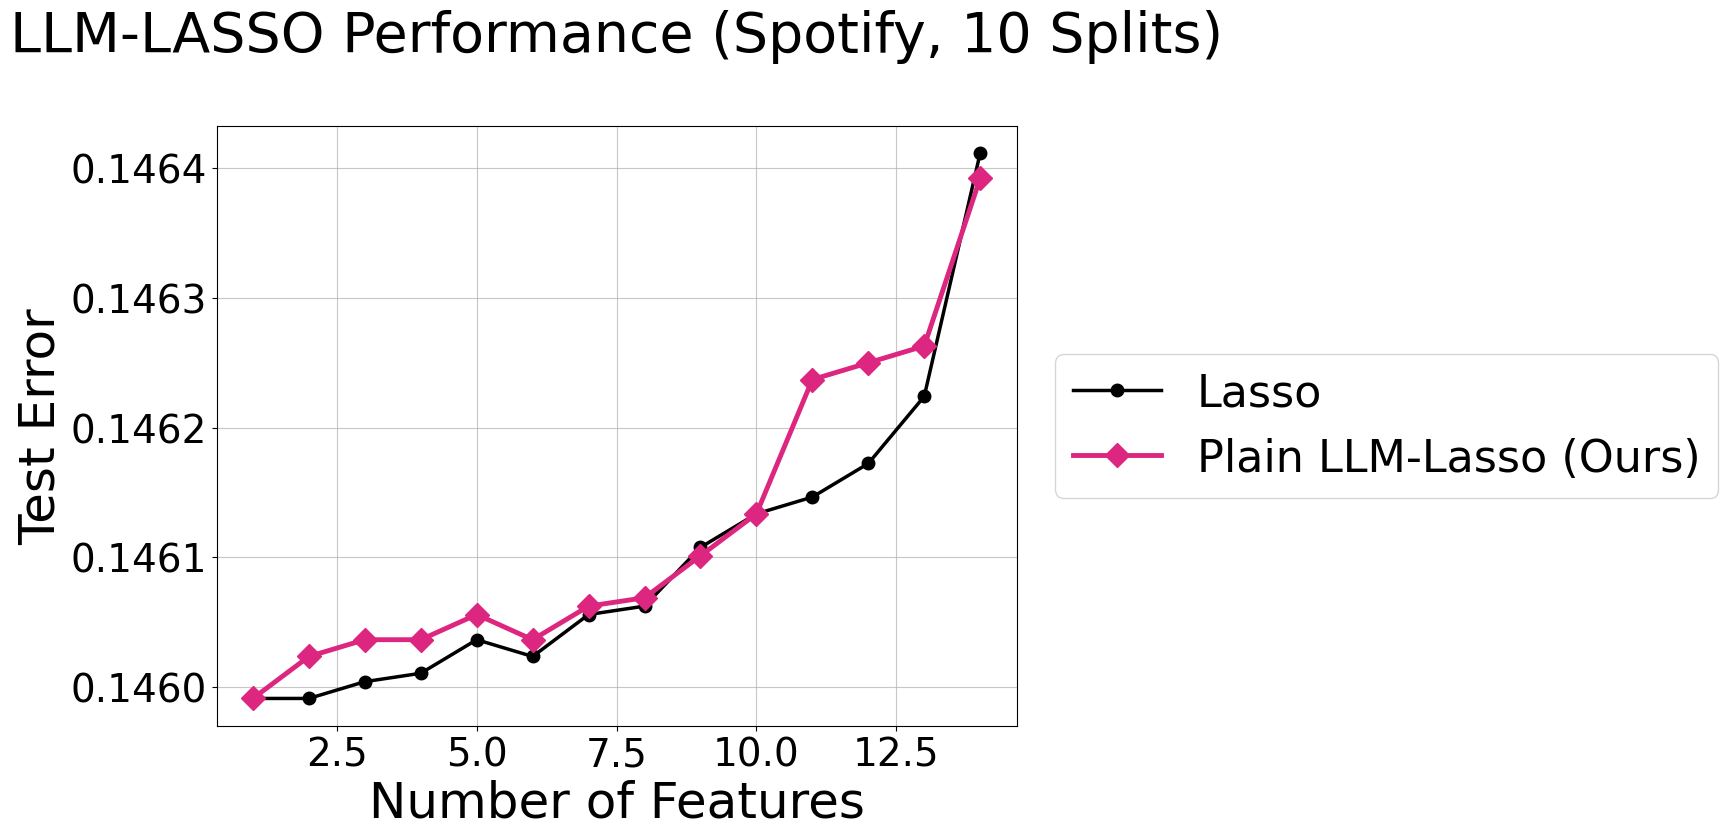

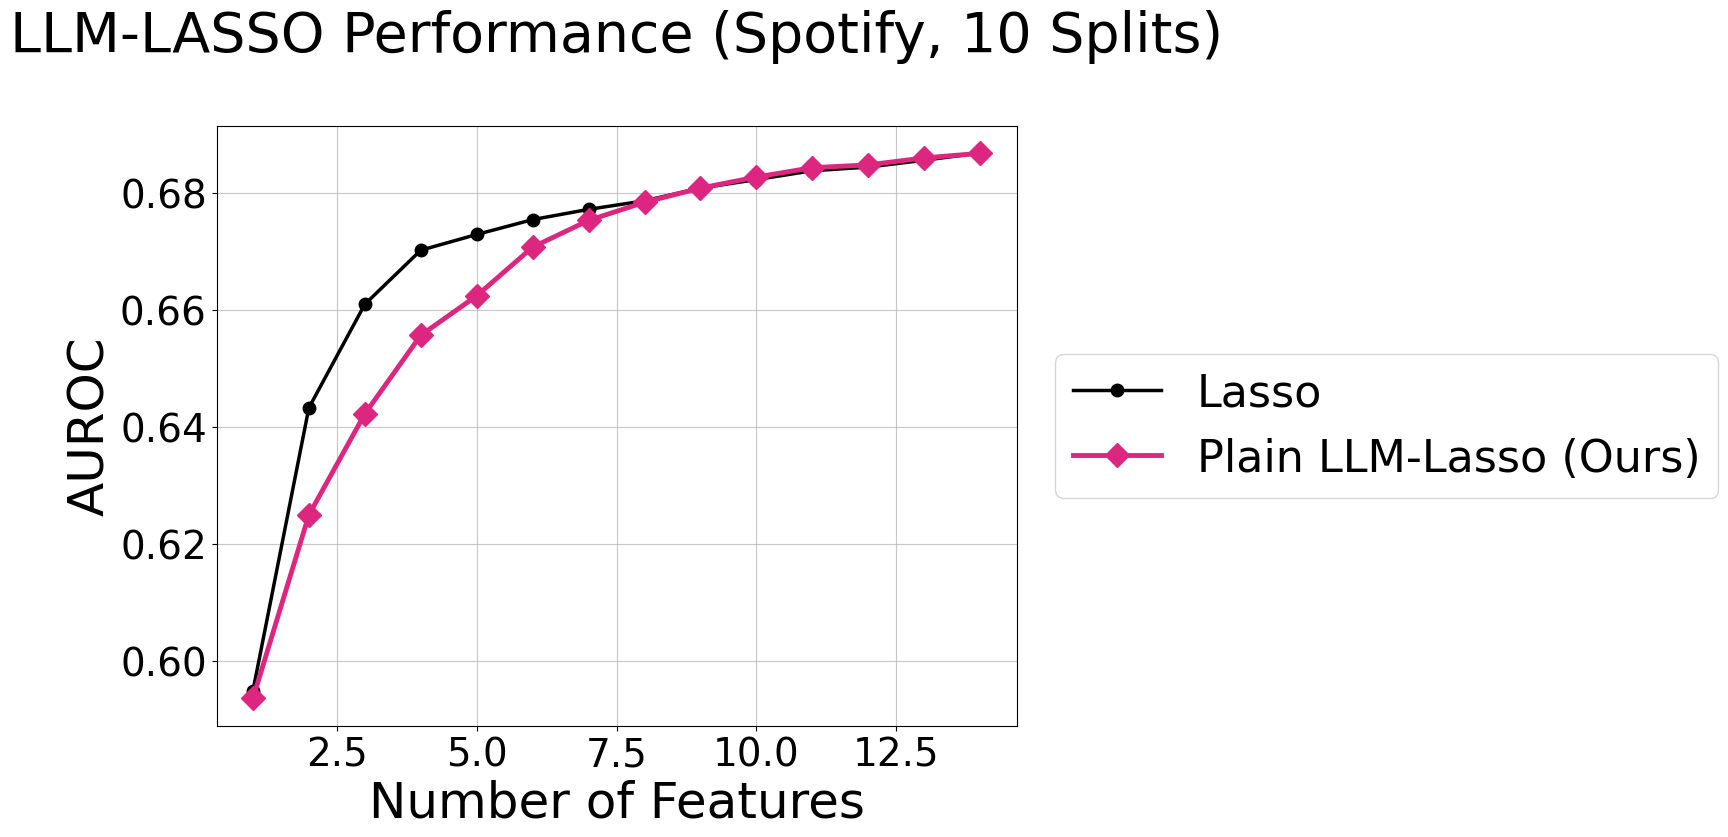

In [25]:
plot_llm_lasso_result(
    dataframes_to_plot,
    bolded_methods=["Plain LLM-Lasso (Ours)"],
    plot_error_bars=False,
    # x_lim=30,
    task="Spotify",
    small_plot=False,
    # test_error_y_lim=(0.125, 0.25)
)

### Adversarial

In [ ]:
N_SPLITS = 10
DATASET="DLBCL_MCL"
BASE_FOLDER="data/experiment-results"
os.makedirs(f"{BASE_FOLDER}/adversarial/{DATASET}", exist_ok=True)
splits = read_train_test_splits(f"data/splits/{DATASET}", N_SPLITS)

In [ ]:
import pickle
with open("data/adversarial/genenames/genes1592/new_genenames.pkl", "rb") as f:
    genenames = pickle.load(f)

In [124]:
genename_mapping = {}
for (old, new) in zip(splits[0].x_train.columns, genenames):
    genename_mapping[old] = new

In [125]:
for i in range(N_SPLITS):
    splits[i].x_train.columns = genenames
    splits[i].x_test.columns = genenames

In [126]:
feature_baseline = read_baseline_splits(f"data/baselines/{DATASET}", n_splits=N_SPLITS, n_features=49)
for key in feature_baseline:
    for i in range(N_SPLITS):
        feature_baseline[key][i] = [genename_mapping[x] for x in feature_baseline[key][i]]

In [132]:
with open(f"data/adversarial/results/MCL/llm-select/gpt-4o/trial_scores_llmselect.json") as f:
    llm_score = json.load(f)
features = splits[0].x_train.columns
scores = np.mean(np.array([scores["scores"] for scores in llm_score]), axis=0)
llm_score_features = features[np.argsort(-scores)].tolist()
feature_baseline["llm_score"] = [llm_score_features] * N_SPLITS

In [137]:
RERUN_BASELINES = False

baseline_csv = f"{BASE_FOLDER}/adversarial/{DATASET}/baselines.csv"
if not RERUN_BASELINES and os.path.exists(baseline_csv):
    print(f"CSV found at {baseline_csv}. Loading.")
    baselines = pd.read_csv(baseline_csv)
else:
    baselines = run_downstream_baselines_for_splits(
        splits=splits,
        feature_baseline=feature_baseline,
        config=config
    )
    baselines.to_csv(baseline_csv, index=False)

CSV found at data/experiment-results/adversarial/DLBCL_MCL/baselines.csv. Loading.


In [138]:
RERUN_LASSO = True
EXPERIMENT_NAME = "base"

lasso_csv = f"{BASE_FOLDER}/adversarial/{DATASET}/lasso_{EXPERIMENT_NAME}.csv"

if not RERUN_LASSO and os.path.exists(lasso_csv):
    print(f"CSV found at {lasso_csv}. Loading.")
    lasso = pd.read_csv(lasso_csv)
else:
    lasso = run_lasso_baseline_for_splits(
        splits=splits,
        config=config
    )
    lasso.to_csv(lasso_csv, index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

1/imp^0 0.0 -inf


 10%|█         | 1/10 [00:04<00:38,  4.30s/it]

1/imp^0 0.0 -inf


 20%|██        | 2/10 [00:08<00:34,  4.26s/it]

1/imp^0 0.0 -inf


 30%|███       | 3/10 [00:13<00:31,  4.43s/it]

1/imp^0 0.0 -inf


 40%|████      | 4/10 [00:17<00:27,  4.55s/it]

1/imp^0 0.0 -inf


 50%|█████     | 5/10 [00:23<00:24,  4.84s/it]

1/imp^0 0.0 -inf


 60%|██████    | 6/10 [00:28<00:19,  4.85s/it]

1/imp^0 0.0 -inf


 70%|███████   | 7/10 [00:32<00:13,  4.60s/it]

1/imp^0 0.0 -inf


 80%|████████  | 8/10 [00:36<00:09,  4.61s/it]

1/imp^0 0.0 -inf


 90%|█████████ | 9/10 [00:41<00:04,  4.68s/it]

1/imp^0 0.0 -inf


100%|██████████| 10/10 [00:46<00:00,  4.64s/it]


In [141]:
penalties_plain = np.array(np.load("data/adversarial/results/MCL/llm-lasso/gpt-4o/plain/gene_scores_RAG.pkl", allow_pickle=True))

In [143]:
RERUN_LLM_LASSO = False
EXPERIMENT_NAME = "base"

llm_lasso_csv = f"{BASE_FOLDER}/adversarial/{DATASET}/llm_lasso_{EXPERIMENT_NAME}.csv"

if not RERUN_LLM_LASSO and os.path.exists(llm_lasso_csv):
    print(f"CSV found at {llm_lasso_csv}. Loading.")
    llm_lasso = pd.read_csv(llm_lasso_csv)
else:
    llm_lasso = run_llm_lasso_cv_for_splits(
        splits=splits,
        scores={
            "plain": penalties_plain,
            # "rag": penalties_rag
        },
        config=config,
    )
    llm_lasso.to_csv(llm_lasso_csv, index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

1/imp^0 0.0 -inf
1/imp^1 0.7937499999999997 0.0


 10%|█         | 1/10 [00:07<01:06,  7.37s/it]

1/imp^0 0.0 -inf
1/imp^1 0.10729166666666687 0.0


 20%|██        | 2/10 [00:13<00:55,  6.92s/it]

1/imp^0 0.0 -inf


 30%|███       | 3/10 [00:20<00:47,  6.81s/it]

1/imp^0 0.0 -inf
1/imp^1 0.2173611111111109 0.0


 40%|████      | 4/10 [00:27<00:40,  6.81s/it]

1/imp^0 0.0 -inf


 50%|█████     | 5/10 [00:34<00:33,  6.78s/it]

1/imp^0 0.0 -inf


 60%|██████    | 6/10 [00:40<00:27,  6.79s/it]

1/imp^0 0.0 -inf


 70%|███████   | 7/10 [00:47<00:20,  6.77s/it]

1/imp^0 0.0 -inf


 80%|████████  | 8/10 [00:54<00:13,  6.80s/it]

1/imp^0 0.0 -inf


 90%|█████████ | 9/10 [01:01<00:06,  6.83s/it]

1/imp^0 0.0 -inf
1/imp^1 0.042361111111111086 0.0


100%|██████████| 10/10 [01:08<00:00,  6.83s/it]


In [148]:
llm_lasso.loc[llm_lasso["method_model"] == "1/imp - rag", "method_model"] = "RAG LLM-Lasso (Ours)"
llm_lasso.loc[llm_lasso["method_model"] == "1/imp - plain", "method_model"] = "Plain LLM-Lasso (Ours)"
baselines = baselines[np.bitwise_or(baselines["method_model"] == "random", baselines["method_model"] == "llm_score")]
dataframes_to_plot = [
    baselines, lasso, llm_lasso
]
# dataframes_to_plot = [
#     lasso, llm_lasso
# ]
dataframes_to_plot = [df[df["n_features"] > 0] for df in dataframes_to_plot]

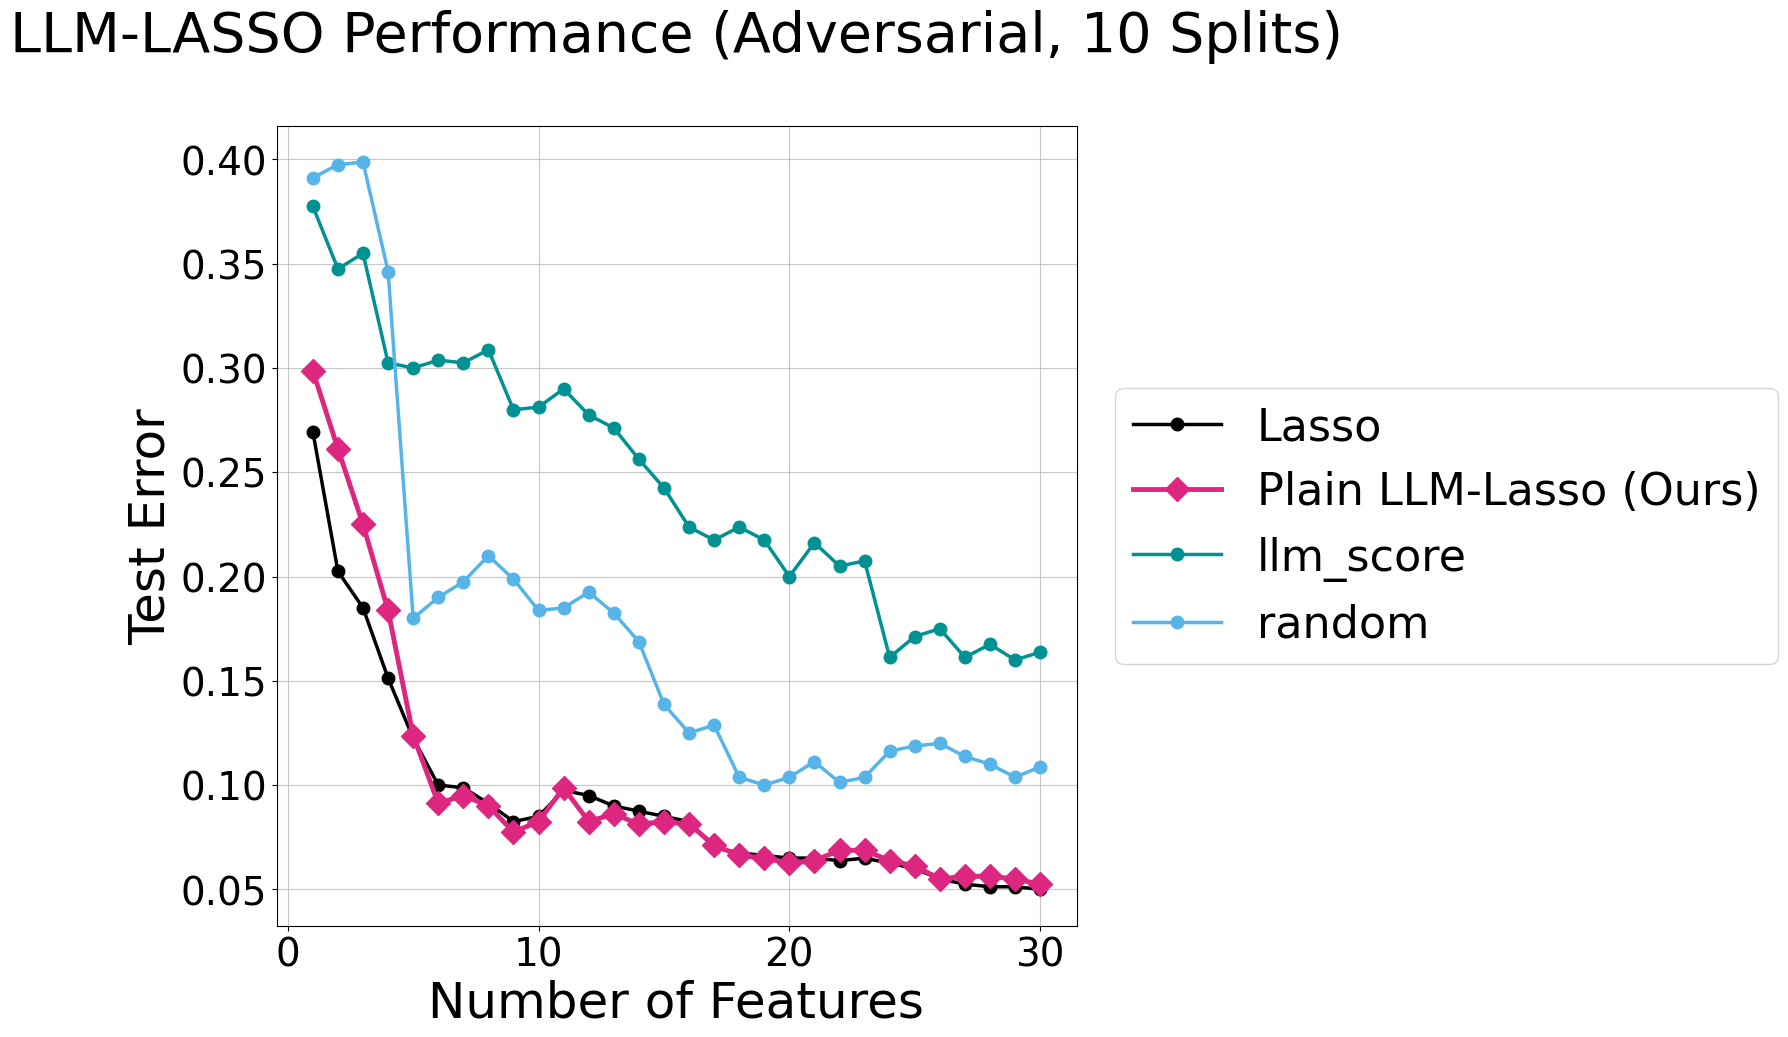

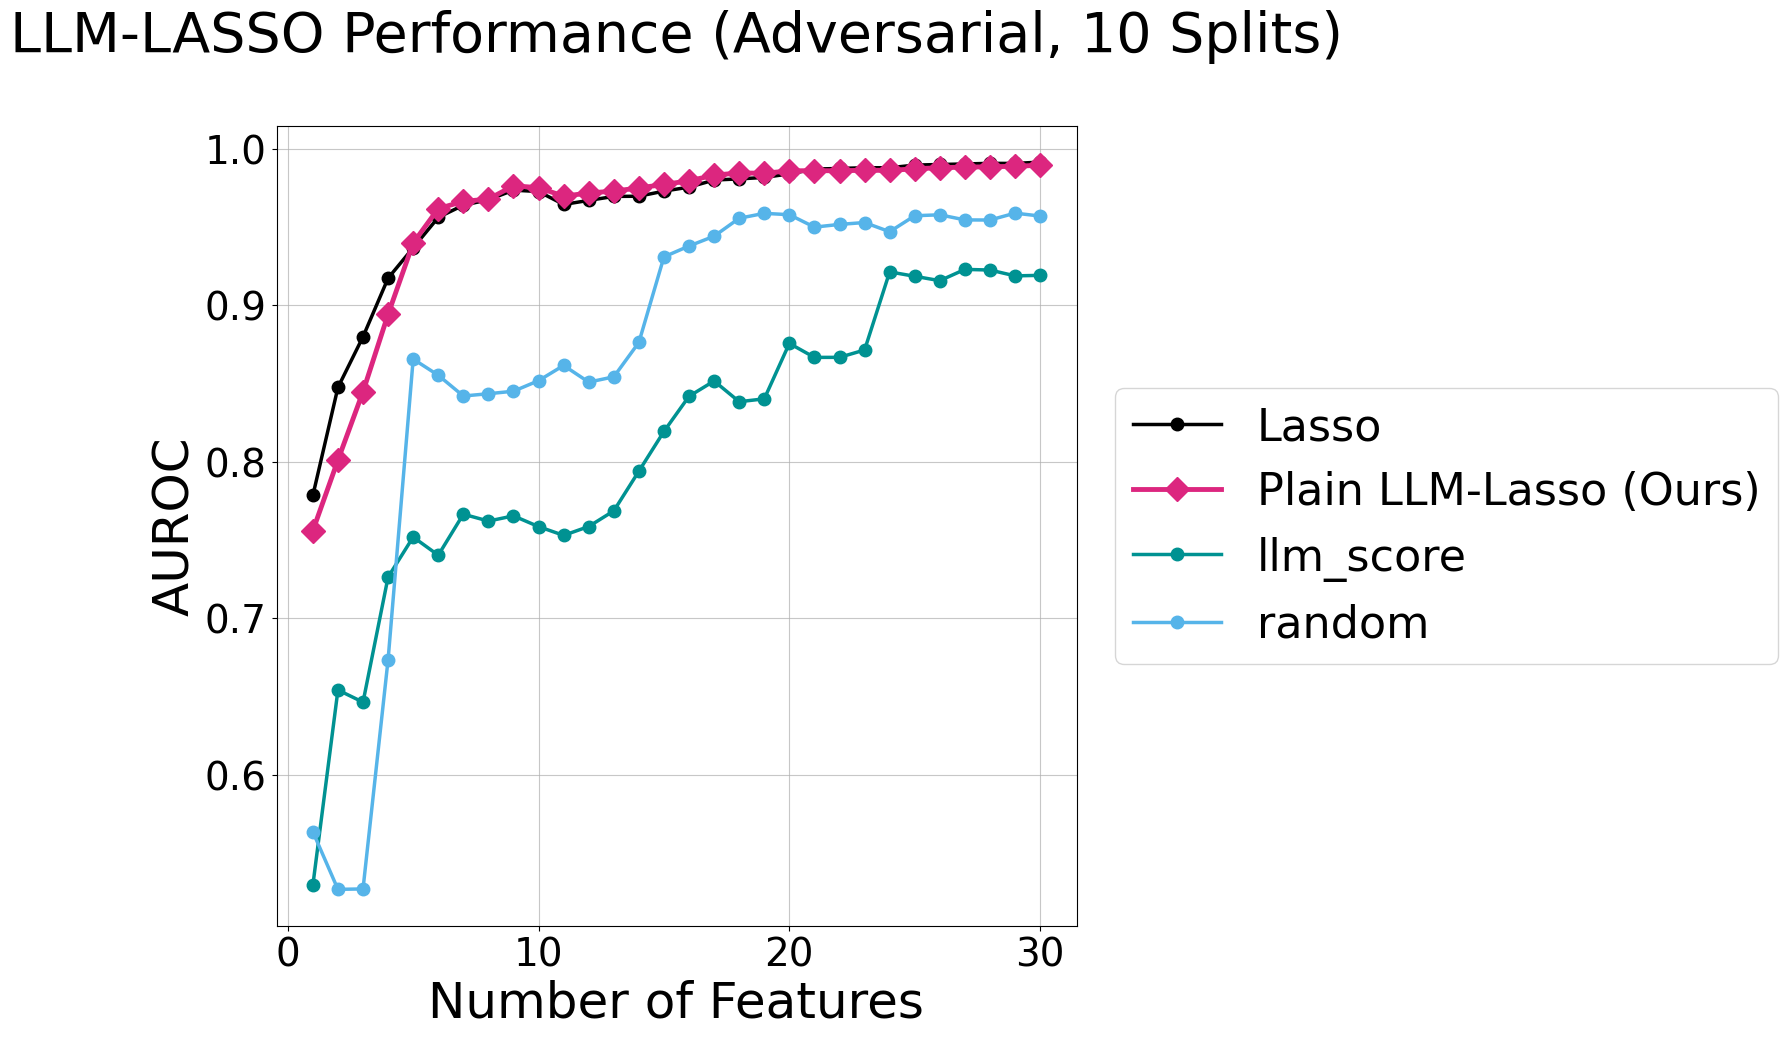

In [155]:
plot_llm_lasso_result(
    dataframes_to_plot,
    bolded_methods=["Plain LLM-Lasso (Ours)"],
    plot_error_bars=False,
    x_lim=30,
    task="Adversarial",
)

## Experimentation on ETP Dataset

### Step 1: Load in Data

In [4]:
N_SPLITS = 10
DATASET="ETP"
BASE_FOLDER="data/experiment-results"
os.makedirs(f"{BASE_FOLDER}/{DATASET}", exist_ok=True)
splits = read_train_test_splits(f"data/splits/{DATASET}", N_SPLITS)

In [5]:
feature_baseline = read_baseline_splits(f"data/baselines/{DATASET}", n_splits=N_SPLITS, n_features=49)

### Step 2: Experiment Config

In [6]:
config = LLMLassoExperimentConfig(
    folds_cv=5,
    regression=False,
    max_features_for_baselines=30,
    n_threads=8,

    # Lasso config
    lambda_min_ratio=0.001,
    relaxed_lasso=False,
    lasso_downstream_l2=True,
    max_imp_power=4,

    remove_correlated_features=False,
    run_pure_lasso_after=8
)

### Step 3: Run Baselines

All experiments (baselines, Lasso, LLM-Lasso, etc.) in this notebook have the same structure:
1. **Step 1**: Look for previous results in the specified CSV file (for the baselines, it's `data/experiment-results/ETP/baselines.csv`, as defined in the variable `baseline_csv` below).
    If the CSV is found, and the variable **`RERUN_BASELINES`** (e.g.) is not set `True`, then we just load in the CSV.
2. **Step 2**: if the CSV is not found, run the experiment, e.g., `run_downstream_baselines_for_splits`.
3. **Step 3**: save the experiments to CSV.

In [ ]:
RERUN_BASELINES = False

baseline_csv = f"{BASE_FOLDER}/{DATASET}/baselines.csv"
if not RERUN_BASELINES and os.path.exists(baseline_csv):
    print(f"CSV found at {baseline_csv}. Loading.")
    baselines = pd.read_csv(baseline_csv)
else:
    baselines = run_downstream_baselines_for_splits(
        splits=splits,
        feature_baseline=feature_baseline,
        config=config
    )
    baselines.to_csv(baseline_csv, index=False)

CSV found at data/experiment-results/ETP/baselines.csv. Loading.


**Note**: for Lasso, LLM-Lasso, and Adaptive Lasso, this notebook defines an **`EXPERIMENT_NAME`** variable, which is added to the CSV filename to allow for saving multiple CSVs in the same directory with different experiment configurations.

In [8]:
RERUN_LASSO = False
EXPERIMENT_NAME = "logistic"

lasso_csv = f"{BASE_FOLDER}/{DATASET}/lasso_{EXPERIMENT_NAME}.csv"

if not RERUN_LASSO and os.path.exists(lasso_csv):
    print(f"CSV found at {lasso_csv}. Loading.")
    lasso = pd.read_csv(lasso_csv)
else:
    lasso = run_lasso_baseline_for_splits(
        splits=splits,
        config=config
    )
    lasso.to_csv(lasso_csv, index=False)

CSV found at data/experiment-results/ETP/lasso_logistic.csv. Loading.


In [9]:
RERUN_ADAPTIVE_LASSO = False
EXPERIMENT_NAME = "logistic"

adaptive_lasso_csv = f"{BASE_FOLDER}/{DATASET}/adaptive_lasso_{EXPERIMENT_NAME}.csv"

if not RERUN_ADAPTIVE_LASSO and os.path.exists(adaptive_lasso_csv):
    print(f"CSV found at {adaptive_lasso_csv}. Loading.")
    adaptive_lasso = pd.read_csv(adaptive_lasso_csv)
else:
    adaptive_lasso = run_adaptive_lasso_for_splits(
        splits=splits,
        config=config
    )
    adaptive_lasso.to_csv(adaptive_lasso_csv, index=False)

CSV found at data/experiment-results/ETP/adaptive_lasso_logistic.csv. Loading.


In [10]:
RERUN_XGBOOST = False

xgboost_csv = f"{BASE_FOLDER}/{DATASET}/xgboost.csv"

if not RERUN_XGBOOST and os.path.exists(xgboost_csv):
    print(f"CSV found at {xgboost_csv}. Loading.")
    xgboost = pd.read_csv(xgboost_csv)
else:
    xgboost = run_xgboost_for_splits(
        splits=splits,
        ordered_features=feature_baseline["xgboost"],
        config=config
    )
    xgboost.to_csv(xgboost_csv, index=False)

CSV found at data/experiment-results/ETP/xgboost.csv. Loading.


In [11]:
penalties = np.array(np.load("data/llm-lasso/etp_experimental_2/final_scores_plain.pkl", allow_pickle=True))

In [ ]:
# trial_scores = None
# with open("data/llm-lasso/etp_experimental_3/trial_scores_plain.json") as f:
#     trial_scores = np.array([x["scores"] for x in json.load(f)])

In [12]:
preselected_feature_names = []
with open("data/preselected/ETP/genes_per_split.txt", "r") as file:
    for line in file.readlines():
        if "," not in line:
            continue
        line = line.split(",")
        preselected_feature_names.append([x.strip() for x in line])

In [15]:
idx = splits[0].x_train.columns.tolist().index("CD1B")

In [16]:
penalties[:, idx]

array([0.26, 0.28, 0.36, 0.3 , 0.48, 0.4 , 0.36, 0.26, 0.46, 0.52])

In [207]:
perturbed_penalties = penalties.copy()
idx = splits[0].x_train.columns.tolist().index("CD1B")
perturbed_penalties[:, idx] /= 2

In [115]:
# cd1a_idx = splits[0].x_train.columns.tolist().index("CD1A")
# idxs_wo_cd1a = list(range(cd1a_idx)) + list(range(cd1a_idx+1, 1000))
# genes_wo_cd1a = [splits[0].x_train.columns[i] for i in idxs_wo_cd1a]
# splits_wo_cd1a = [
#     TrainTest(split.x_train[genes_wo_cd1a], split.x_test[genes_wo_cd1a], split.y_train, split.y_test) \
#         for split in splits
# ]
# pf_wo_cd1a = penalties[:, idxs_wo_cd1a]


In [17]:
RERUN_LLM_LASSO = True
EXPERIMENT_NAME = "chatgpt"

llm_lasso_csv = f"{BASE_FOLDER}/{DATASET}/llm_lasso_{EXPERIMENT_NAME}.csv"

if not RERUN_LLM_LASSO and os.path.exists(llm_lasso_csv):
    print(f"CSV found at {llm_lasso_csv}. Loading.")
    llm_lasso = pd.read_csv(llm_lasso_csv)
else:
    llm_lasso = run_llm_lasso_cv_for_splits(
        splits=splits,
        scores={"plain": penalties},
        config=config,
        verbose=True,
        preselected_genes=preselected_feature_names
        # score_trial_list={"plain": trial_scores}
    )
    llm_lasso.to_csv(llm_lasso_csv, index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Running model: plain
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4


 10%|█         | 1/10 [00:06<00:59,  6.62s/it]

Running model: plain
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4


 20%|██        | 2/10 [00:11<00:46,  5.85s/it]

Running model: plain
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4


 30%|███       | 3/10 [00:17<00:39,  5.71s/it]

Running model: plain
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3


2025-05-02 17:10:01,816 - root - ERROR - adelie_core solver: max coordinate descents reached at lambda index: 0. (state.py:164)


ERROR lmdas must be non-empty!
Running pf_type 1/imp^4


2025-05-02 17:10:02,181 - root - ERROR - adelie_core solver: max coordinate descents reached at lambda index: 0. (state.py:164)


ERROR lmdas must be non-empty!


 40%|████      | 4/10 [00:21<00:31,  5.19s/it]

Running model: plain
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3


2025-05-02 17:10:06,961 - root - ERROR - adelie_core solver: max coordinate descents reached at lambda index: 0. (state.py:164)


Running pf_type 1/imp^4
ERROR lmdas must be non-empty!


 50%|█████     | 5/10 [00:26<00:25,  5.04s/it]

Running model: plain
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4


 60%|██████    | 6/10 [00:31<00:20,  5.14s/it]

Running model: plain
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4


 70%|███████   | 7/10 [00:37<00:15,  5.26s/it]

Running model: plain
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3


2025-05-02 17:10:22,206 - root - ERROR - adelie_core solver: max coordinate descents reached at lambda index: 0. (state.py:164)


ERROR lmdas must be non-empty!
Running pf_type 1/imp^4


2025-05-02 17:10:22,776 - root - ERROR - adelie_core solver: max coordinate descents reached at lambda index: 0. (state.py:164)


ERROR lmdas must be non-empty!


 80%|████████  | 8/10 [00:42<00:10,  5.17s/it]

Running model: plain
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4


 90%|█████████ | 9/10 [00:47<00:05,  5.22s/it]

Running model: plain
Running pf_type 1/imp^0
Running pf_type 1/imp^1
Running pf_type 1/imp^2
Running pf_type 1/imp^3
Running pf_type 1/imp^4


/home/nsagan/micromamba/envs/llm-lasso/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 10/10 [00:53<00:00,  5.35s/it]
/home/nsagan/git-managed/pilancilab-LLM-Lasso/src/llm_lasso/task_specific_lasso/llm_lasso.py:343: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_results['method_model'] = all_res

In [18]:
# This line means that we only plot a few of the (better-performing) baselines!
filtered_baselines = baselines[baselines["method"].isin(["xgboost", "XGBoost_Model", "mrmr", "mi"])]

dataframes_to_plot = [
    filtered_baselines, lasso, xgboost, llm_lasso, adaptive_lasso
]

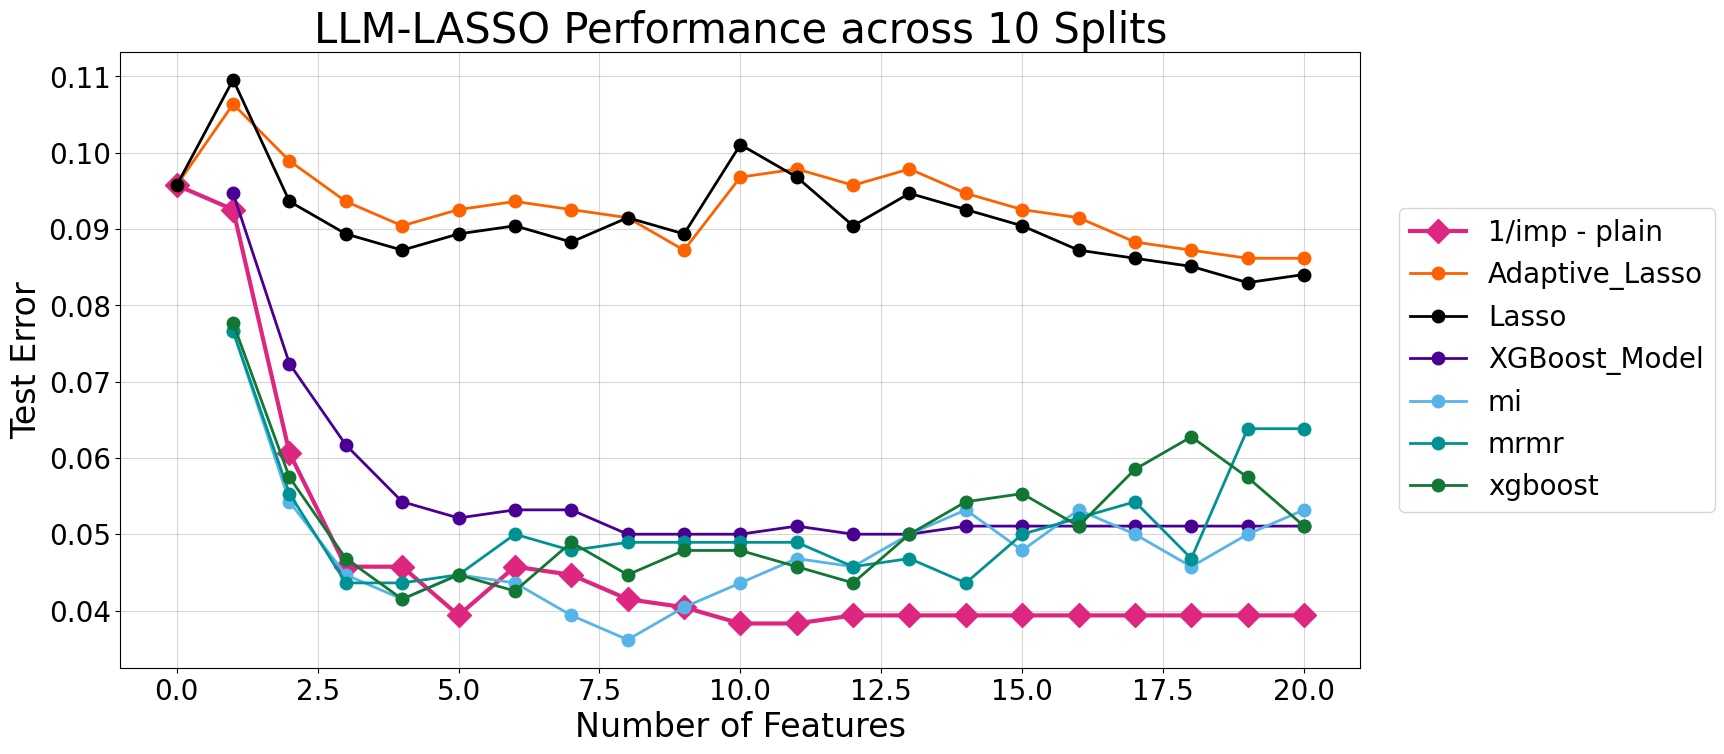

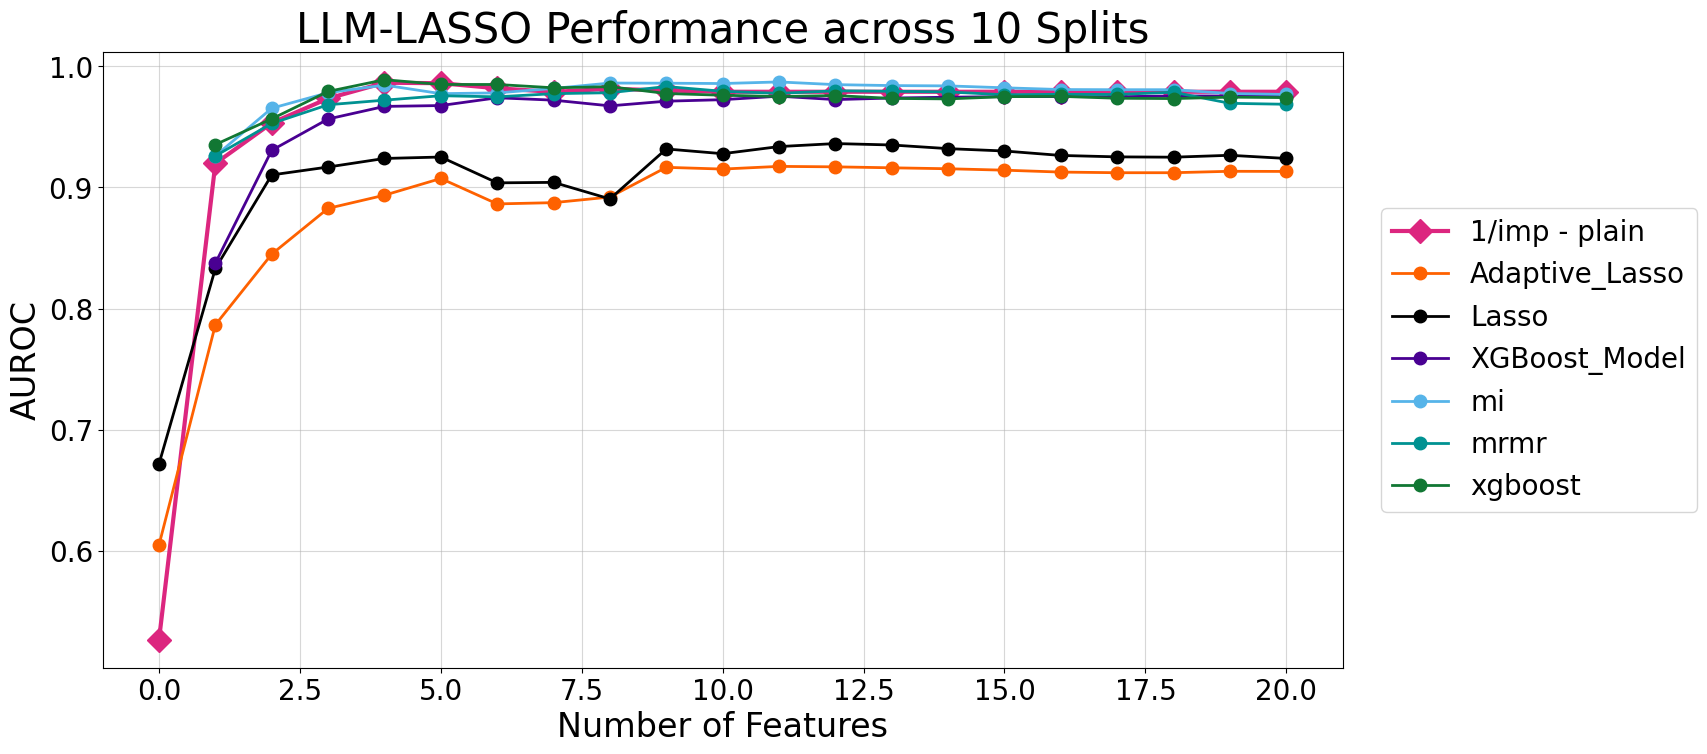

In [19]:
plot_llm_lasso_result(
    dataframes_to_plot,
    bolded_methods=["1/imp - plain"],
    plot_error_bars=False,
    x_lim=20
)

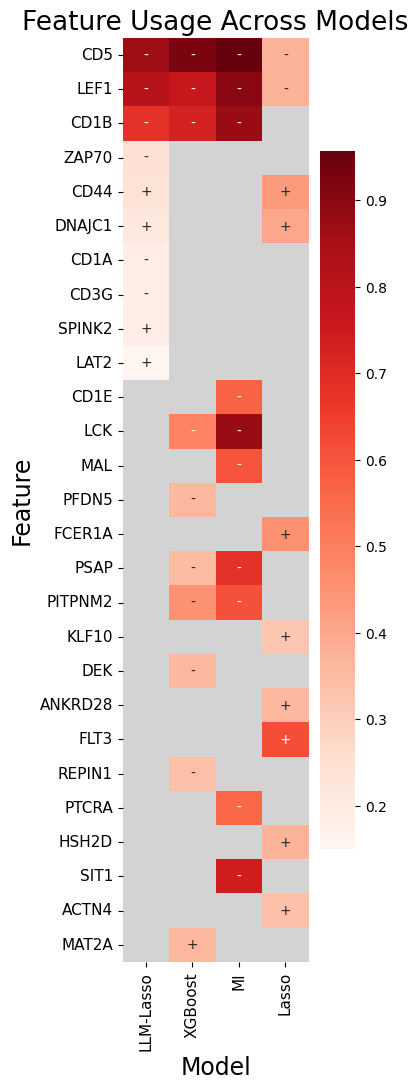

In [211]:
plot_heatmap(
    dataframes_to_plot,
    method_models=["1/imp - plain", "xgboost", "mi", "Lasso"], # these are from the method_model column of the dataframe
    labels=["LLM-Lasso", "XGBoost", "MI", "Lasso"], # this is how each method_model will be labeled on the plot
    feature_names=splits[0].x_train.columns,
    sort_by="LLM-Lasso"
)

### The below is some experimentation with prompt tuning

In [ ]:
from llm_lasso.llm_penalty.llm import LLMQueryWrapperWithMemory, LLMType

In [ ]:
prompt = """
In using gene expression levels for classifying ETP-All vs. non-ETP-All, assign each of these genes a score between 0.1 and 0.9, where 0.1 means very important and 0.9 means less important. It's ok to assign many genes 0.9 if they aren't super important. It's normal for only a few genes to be important.

Think carefully for each gene. Format your response as a JSON.

""" + str(sorted(feature_baseline["xgboost"][9]))

In [ ]:
print(prompt)

In [ ]:
import os
import constants
os.environ["OPENAI_API_KEY"] = constants.OPENAI_API

In [ ]:
llm = LLMQueryWrapperWithMemory(
    llm_type=LLMType.O1,
    llm_name="o1",
    api_key=constants.OPENAI_API
)

In [ ]:
output_json = llm.query(
    system_message="",
    full_prompt=prompt,
    sleep_time=1
)

In [ ]:
print(output_json)